In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

### Data inlezen

Poging om een RFM-analyse (<https://en.wikipedia.org/wiki/RFM_(market_research)>) van de klanten van bibliotheek Aalter te maken.

Er is een csv gemaakt met een rij per aktie die in de wiselog is opgeslagen (loghfdnu en loghfdnu_archief), gecombineerd met gegevens uit de actor-tabellen en de actor-tellers om ook een historiek te krijgen die verder teruggaat dan de logtabellen (die pas met de overstap naar Wise consequent en volledig zijn).

Elke rij is een transactie uit de log met onderstaande kolommen:

 |index|kolomnaam               |uitleg|
 |-----|------------------------|------|
 |0  | aktie_datum              |datum van transactie|
 |1  | aktie                    |soort transactie (1=uitleninge, 3=verlenging)      |
 |2  | materiaal                |RMT van exemplaar     |
 |3  | aktie_vest               |vestiging van transactie      |
 |4  | inschrijfdatum_verkeerd  |inschrijfdatum uit tabel rol (=rol.startdatum)|
 |5  | ab_nr                    |abonnement van lener op moment van query (komt uit rol_abonnement, niet loghfdnu)       |
 |6  | postcode                 |postcode van lener      |
 |7  | sexe                     |geslacht van lener      |
 |8  | geboortejaar             |geboortejaar van lener       |
 |9  | totaal                   |som van alle transacties in de tellers voor deze lener in deze instantie       |
 |10 | min_jaar                 |oudste jaar in tellers voor deze lener in deze instantie       |
 |11 | max_jaar                 |recentste jaar in tellers voor deze lener in deze instantie       |
 |12 | id                       |hash voor lener |

In [2]:
data = pd.read_csv('RFM_data.csv', parse_dates=[0,4])

# categorische data omzetten naar apart dtype
cat_cols = ['aktie', 'materiaal', 'aktie_vest', 'postcode', 'sexe']
data[cat_cols] = data[cat_cols].astype('category')

# lege waardes bij totaal vullen met 0
data['totaal'] = data['totaal'].fillna(0)

# print(data.info())
display(data.head(3))

c:\python\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,aktie_datum,aktie,materiaal,aktie_vest,inschrijfdatum_verkeerd,ab_nr,postcode,sexe,geboortejaar,totaal,min_jaar,max_jaar,aantal_jaar,id
0,2021-06-28,3.0,B3,3070.0,2001-01-27,100.0,9880,V,1964.0,2650.0,2009.0,2023.0,15,5528102563742870639
1,2021-08-03,1.0,B4,3073.0,2001-01-27,100.0,9880,V,1964.0,2650.0,2009.0,2023.0,15,5528102563742870639
2,2021-08-17,1.0,B3,3070.0,2001-01-27,100.0,9880,V,1964.0,2650.0,2009.0,2023.0,15,5528102563742870639


### Data aanvullen / verbeteren

Omdat de inschrijfdatum soms werd overschreven door Wise is een correctie uitgevoerd op dit veld. Wanneer het oudste jaar in de tellers voor een lener verder teruggaat dan de inschrijfdatum is de inschrijfdatum op 1 januari van dat jaar gezet.

Bij leners die volgens de tellers wel uitleningen hebben gedaan maar geen transacties in de log hebben is er op de regel voor deze lener een aktie_datum op 31 december van het meest recente jaar in de tellers toegevoegd.

Bij leners die geen transacties in de log hebben en ook geen tellers is de datum voor transactie gelijk gezet aan de - verbeterde - inschrijfdatum.

In [3]:
# inschrijfdatum verbeteren

# inschrijfdatum verbeteren waar die later is dan oudste jaar in tellers (naar 01/01/jaar_oudste_teller)

# kolom voor juiste datum maken
data['inschrijfdatum'] = pd.to_datetime(data['inschrijfdatum_verkeerd'], format='%Y-%m-%d')

# fouten selecteren: 
# 1. inschrijfdatum is groter dan kleinste jaar in tellers => inschrijfdatum wordt 01/01/min_jaar
inschrijf_datum_aanpassen = data['inschrijfdatum_verkeerd'].dt.year > data['min_jaar']  
data.loc[inschrijf_datum_aanpassen, 'inschrijfdatum'] = pd.to_datetime(data.loc[inschrijf_datum_aanpassen, 'min_jaar'], 
                                                                       format='%Y') # naar 1 jan van min_jaar zetten

# 2. inschrijfdatum is groter dan kleinste transactiedatum bij lener => inschrijfdatum wordt kleinste transactiedatum
# hier ook nan-waardes in min_jaar wegwerken met 0 om die fouten op te pikken

# kleinste actiedatum per lener berekenen
min_aktie_datum = data.groupby('id', as_index=False)\
                      .agg(min_aktie_datum = ('aktie_datum', np.min))


# toevoegen als kolom in tijdelijke tabel
data_tmp = data.copy()
data_tmp = data_tmp.merge(min_aktie_datum, on='id', how='left')

# filter maken waar inschrijfdatum moet verbeterd worden
inschrijf_datum_aanpassen2 = ( (data_tmp['inschrijfdatum'].dt.year > data_tmp['min_jaar'].fillna(1900)) &
                               (data_tmp['inschrijfdatum'] > data_tmp['min_aktie_datum'])
                             )

# inschrijfdatum gelijk zetten met min_aktie_datum als die kleiner is dan inschrijfdatum
data_tmp.loc[inschrijf_datum_aanpassen2, 'inschrijfdatum'] = data_tmp.loc[inschrijf_datum_aanpassen2, 'min_aktie_datum']

# verbetering ook doorzetten naar echte datatabel en tijdelijke tabel uit geheugen halen
data['inschrijfdatum'] = data_tmp.inschrijfdatum
del(data_tmp)


# controle inschrijfdatum
controle_inschrijfdatum = data[data['inschrijfdatum'].dt.year > data['min_jaar']].shape[0]
print(f'aantal leners met teller ouder dan inschrijfdatum: {controle_inschrijfdatum}')
print()


# aktiedatum invullen bij leners die niet in transactielog zaten (om datum laatste transactie te kunnen berekenen)
zonder_transactie_wel_teller = data['aktie_datum'].isnull() & data['max_jaar'].notnull()
zonder_transactie_geen_teller = data['aktie_datum'].isnull() & data['max_jaar'].isnull()
print('leners zonder transactie met teller vóór:', len(data[zonder_transactie_wel_teller]))
print('leners zonder transactie zonder teller vóór:', len(data[zonder_transactie_geen_teller]))
print()


# bij leners zonder teller de inschrijfdatum als aktie_datum instellen
data.loc[zonder_transactie_geen_teller, 'aktie_datum'] = data.loc[zonder_transactie_geen_teller, 'inschrijfdatum']


# bij leners met teller 31/12 van max_jaar invullen
data.loc[zonder_transactie_wel_teller, 'aktie_datum'] = pd.to_datetime(data.loc[zonder_transactie_wel_teller, 'max_jaar'], 
                                                                       format='%Y') + pd.offsets.YearEnd(0)

zonder_transactie_wel_teller = data['aktie_datum'].isnull() & data['max_jaar'].notnull()
zonder_transactie_geen_teller = data['aktie_datum'].isnull() & data['max_jaar'].isnull()
print('leners zonder transactie met teller na:', len(data[zonder_transactie_wel_teller]))
print('leners zonder transactie zonder teller na:', len(data[zonder_transactie_geen_teller]))
print()


# print(data.info())
display(data.head(3))

aantal leners met teller ouder dan inschrijfdatum: 0

leners zonder transactie met teller vóór: 6973
leners zonder transactie zonder teller vóór: 855

leners zonder transactie met teller na: 0
leners zonder transactie zonder teller na: 0



,aktie_datum,aktie,materiaal,aktie_vest,inschrijfdatum_verkeerd,ab_nr,postcode,sexe,geboortejaar,totaal,min_jaar,max_jaar,aantal_jaar,id,inschrijfdatum
0,2021-06-28,3.0,B3,3070.0,2001-01-27,100.0,9880,V,1964.0,2650.0,2009.0,2023.0,15,5528102563742870639,2001-01-27
1,2021-08-03,1.0,B4,3073.0,2001-01-27,100.0,9880,V,1964.0,2650.0,2009.0,2023.0,15,5528102563742870639,2001-01-27
2,2021-08-17,1.0,B3,3070.0,2001-01-27,100.0,9880,V,1964.0,2650.0,2009.0,2023.0,15,5528102563742870639,2001-01-27


## Recency ~ laatste activiteit

Bij elke lener berekenen wat de meest recente datum van activiteit (uitlening of verlenging) was. Het verschil tussen 
de datum van uitvoeren van query (=30/07/2023) en datum van laatste activiteit berekenen in aantal jaar (decimaal).

Opslaan in de kolom *laatst_actief_jaar* (vb 5,5 = lener was laatst actief 5 en een half jaar geleden)

In [4]:
# dagen sinds laatste activiteit berekenen

dataR = data.copy()
dataR = dataR[['aktie_datum', 'id']]
dataR = dataR.groupby('id',as_index=False).agg(laatst_actief = ('aktie_datum', np.max))
dataR['laatst_actief_jaar'] = round((pd.Timestamp('2023-07-30') - dataR['laatst_actief']).dt.days / 365, 1)


# print(dataR.info())
display(dataR.head(3))


,id,laatst_actief,laatst_actief_jaar
0,-9222899449976141211,2018-12-31,4.6
1,-9222559721836707953,2016-12-31,6.6
2,-9220858718851160672,2023-07-22,0.0


De leners indelen in bins op basis van aantal jaar sinds laatste activiteit. 

Vijf bins gemaakt:

|R_value| R_label|
|-------|--------|
| 5 | 'Minder dan 1 jaar geleden'|
| 4 | 'Tussen 1 en 2 jaar geleden'|
| 3 | 'Tussen 2 en 5 jaar geleden'|
| 2 | 'Tussen 5 en 10 jaar geleden'|
| 1 | 'Meer dan 10 jaar geleden'|

,id,laatst_actief,laatst_actief_jaar,R_value,R_label
0,-9222899449976141211,2018-12-31,4.6,3,Tussen 2 en 5 jaar geleden
1,-9222559721836707953,2016-12-31,6.6,2,Tussen 5 en 10 jaar geleden
2,-9220858718851160672,2023-07-22,0.0,5,Minder dan 1 jaar geleden
3,-9220718242157652782,2010-12-31,12.6,1,Meer dan 10 jaar geleden
4,-9220226925966244657,2013-12-31,9.6,2,Tussen 5 en 10 jaar geleden


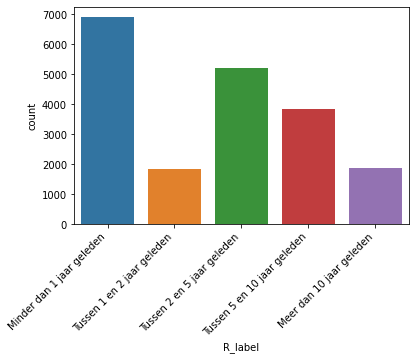

In [5]:
# leners onderverdelen in groepen obv laatste activiteit

# indeling obv aantal jaar bepalen (0, 1-2, 2-5, 5-10, 10+)
bins = [0, 1, 2, 5, 10, max(dataR['laatst_actief_jaar'])]

dataR['R_value'] = pd.cut(dataR['laatst_actief_jaar'], bins=bins, labels=[5,4,3,2,1],
                          include_lowest=True)  

dataR['R_label'] = dataR['R_value'].map({5: 'Minder dan 1 jaar geleden',
                                         4: 'Tussen 1 en 2 jaar geleden',
                                         3: 'Tussen 2 en 5 jaar geleden',
                                         2: 'Tussen 5 en 10 jaar geleden',
                                         1: 'Meer dan 10 jaar geleden'                                        
                                        })

display(dataR.head())

# display(dataR.value_counts('R_label', normalize=True))
fig, ax = plt.subplots()
sns.countplot(data=dataR, x='R_label', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

## Frequency ~ bibliotheekbezoeken

Om de frequentie te tellen is gekozen om het aantal unieke aktie_datums voor een lener in de log te tellen. Dit zou moeten overeenkomen met het aantal bibliotheekbezoeken (en verlengingen via MB). Deze meting heeft wel het nadeel dat enkel recente transacties (sinds overstap naar Wise) kunnen gemeten worden en dus enkel leners met relatief recente activiteit een relevante meting geven.

In [6]:
# Frequentie bepalen

dataF = data.copy()
dataF = dataF.groupby('id', as_index=False)\
             .agg(frequentie= ('aktie_datum', pd.Series.nunique))  # aantal unieke aktiedatums per lener berekenen



display(dataF.head(3))


,id,frequentie
0,-9222899449976141211,1
1,-9222559721836707953,1
2,-9220858718851160672,77


### Ook berekenen hoe lang de lener al lid was

Door het verschil te nemen tussen de datum van de query (30-07-2023) en de inschrijfdatum meten hoe lang een lener al lid is. Door het verschil te nemen tussen de datum van laatste activiteit en de inschrijfdatum krijg je een aanduiding van hoe lang een lener actief is.

Hiermee kunnen de metingen dan relatief gemaakt worden aan de tijd dat een lener actief was (transacties per jaar, bezoeken per jaar,...)

In [7]:
# jaren lidmaatschap en actieve periode berekenen

dataL = data.copy()
dataL = dataL[['id', 'inschrijfdatum']]  # enkel deze kolommen overhouden
dataL = dataL.drop_duplicates()  # 1 rij per lener overhouden

# aantal jaar tussen querydatum en inschrijfdatum berekenen
dataL['jaren_lid'] = round((pd.Timestamp('2023-07-30') - dataL['inschrijfdatum']).dt.days / 365, 1)
# overtollige kolommen weglaten
dataL = dataL[['id', 'inschrijfdatum', 'jaren_lid']]

# data van laatste bezoek toevoegen
dataLR = dataR.merge(dataL, on='id')

# actieve periode berekenen op verschil tussen inschrijfdatum en datum laatste activiteit (in jaar)
# dataLR['dagen_actief'] = (dataLR['laatst_actief'] - dataLR['inschrijfdatum']).dt.days
dataLR['jaren_actief'] = round((dataLR['laatst_actief'] - dataLR['inschrijfdatum']).dt.days / 365, 1)

display(dataLR.head(3))
# dataLR.describe(percentiles=[0.10, 0.25, 0.33, 0.5, 0.66, 0.75, 0.90])



,id,laatst_actief,laatst_actief_jaar,R_value,R_label,inschrijfdatum,jaren_lid,jaren_actief
0,-9222899449976141211,2018-12-31,4.6,3,Tussen 2 en 5 jaar geleden,2012-09-25,10.8,6.3
1,-9222559721836707953,2016-12-31,6.6,2,Tussen 5 en 10 jaar geleden,2016-03-30,7.3,0.8
2,-9220858718851160672,2023-07-22,0.0,5,Minder dan 1 jaar geleden,2009-01-01,14.6,14.6


Frequentie per actief jaar berekenen

In [8]:
# frequentie / jaren_actief = rel_freq

dataFLR = dataF.merge(dataLR, on='id')
dataFLR['rel_freq'] = dataFLR['frequentie'] / (dataFLR['jaren_actief'] + 0.83) # 0.83 = 1 maand om nooit door nul te delen
dataFLR.sort_values(by='rel_freq')


,id,frequentie,laatst_actief,laatst_actief_jaar,R_value,R_label,inschrijfdatum,jaren_lid,jaren_actief,rel_freq
6909,-2857125643622095253,1,2023-05-02,0.2,5,Minder dan 1 jaar geleden,1991-04-15,32.3,32.1,0.030367
8721,-1153833873171683790,1,2022-04-28,1.3,4,Tussen 1 en 2 jaar geleden,1991-03-21,32.4,31.1,0.031319
15205,4918909845551099687,1,2019-12-31,3.6,3,Tussen 2 en 5 jaar geleden,1991-03-28,32.4,28.8,0.033750
14806,4560257522336487361,1,2019-12-31,3.6,3,Tussen 2 en 5 jaar geleden,1991-04-29,32.3,28.7,0.033864
6188,-3498200363026076164,1,2019-10-14,3.8,3,Tussen 2 en 5 jaar geleden,1991-04-02,32.3,28.6,0.033979
...,...,...,...,...,...,...,...,...,...,...
4612,-4988732376001909203,323,2023-07-26,0.0,5,Minder dan 1 jaar geleden,2015-10-09,7.8,7.8,37.427578
8067,-1774942395285864288,102,2023-07-28,0.0,5,Minder dan 1 jaar geleden,2021-11-22,1.7,1.7,40.316206
2005,-7420637209159625995,141,2023-07-18,0.0,5,Minder dan 1 jaar geleden,2020-12-28,2.6,2.6,41.107872
11466,1449947005739421413,204,2023-07-27,0.0,5,Minder dan 1 jaar geleden,2019-10-30,3.8,3.7,45.033113


Leners in bins verdelen op van basis van relatieve frequentie aan bibliotheekbezoeken. Leners opgedeeld in 4 categorieën:

|F_value|F_label|uitleg|
|-------|-------|------|
|      1| < 1 x per jaar|
|      2| 1-4 x per jaar|
|      3| 4-12 x per jaar|
|      4| > 12 x per jaar|


,id,frequentie,laatst_actief,laatst_actief_jaar,R_value,R_label,inschrijfdatum,jaren_lid,jaren_actief,rel_freq,F_value,F_label
0,-9222899449976141211,1,2018-12-31,4.6,3,Tussen 2 en 5 jaar geleden,2012-09-25,10.8,6.3,0.140252,1,< 1 x per jaar
1,-9222559721836707953,1,2016-12-31,6.6,2,Tussen 5 en 10 jaar geleden,2016-03-30,7.3,0.8,0.613497,1,< 1 x per jaar
2,-9220858718851160672,77,2023-07-22,0.0,5,Minder dan 1 jaar geleden,2009-01-01,14.6,14.6,4.990279,3,4-12 x per jaar


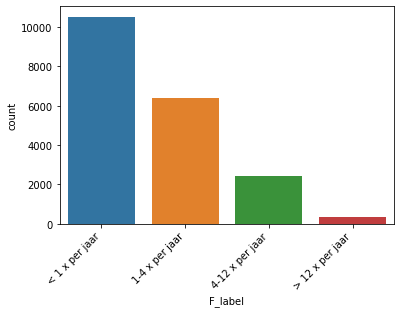

< 1 x per jaar     0.534397
1-4 x per jaar     0.325526
4-12 x per jaar    0.122650
> 12 x per jaar    0.017427
Name: F_label, dtype: float64

In [9]:
# opdelen in bins
# bins = np.percentile(dataFLR['rel_freq'], [0, 50, 75, 95, 100])
bins = [0, 1, 4, 12, np.max(dataFLR['rel_freq'])]
labels = ['< 1 x per jaar', '1-4 x per jaar', '4-12 x per jaar', '> 12 x per jaar']

dataFLR['F_value'] = pd.cut(dataFLR['rel_freq'], labels=[1, 2, 3, 4], bins=bins, include_lowest=True)
dataFLR['F_label'] = dataFLR['F_value'].map(dict(zip([1, 2, 3, 4], labels)))

display(dataFLR.head(3))

fig, ax = plt.subplots()
sns.countplot(data=dataFLR, x='F_label', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

display(dataFLR['F_label'].value_counts(normalize=True))


De leners indelen in bins op basis van aantal jaar dat ze lid zijn. 

Vijf bins gemaakt:

|L_value| L_label|
|-------|--------|
| 5 | 'Minder dan 1 jaar lid'|
| 4 | 'Tussen 1 en 2 jaar lid'|
| 3 | 'Tussen 2 en 5 jaar lid'|
| 2 | 'Tussen 5 en 10 jaar lid'|
| 1 | 'Meer dan 10 jaar lid'|

,id,frequentie,laatst_actief,laatst_actief_jaar,R_value,R_label,inschrijfdatum,jaren_lid,jaren_actief,rel_freq,F_value,F_label,L_value,L_label
0,-9222899449976141211,1,2018-12-31,4.6,3,Tussen 2 en 5 jaar geleden,2012-09-25,10.8,6.3,0.140252,1,< 1 x per jaar,5,meer dan 10 jaar lid
1,-9222559721836707953,1,2016-12-31,6.6,2,Tussen 5 en 10 jaar geleden,2016-03-30,7.3,0.8,0.613497,1,< 1 x per jaar,4,tussen 5 en 10 jaar lid
2,-9220858718851160672,77,2023-07-22,0.0,5,Minder dan 1 jaar geleden,2009-01-01,14.6,14.6,4.990279,3,4-12 x per jaar,5,meer dan 10 jaar lid


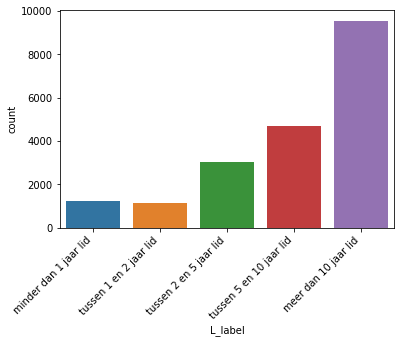

In [10]:
# opdelen in bins
bins = [0, 1, 2, 5, 10, max(dataFLR['jaren_lid'])]
labels = ['minder dan 1 jaar lid', 'tussen 1 en 2 jaar lid', 'tussen 2 en 5 jaar lid', 
          'tussen 5 en 10 jaar lid', 'meer dan 10 jaar lid']

dataFLR['L_value'] = pd.cut(dataFLR['jaren_lid'], labels=[1, 2, 3, 4, 5], bins=bins, include_lowest=True)
dataFLR['L_label'] = dataFLR['L_value'].map(dict(zip([1, 2, 3, 4, 5], labels)))

display(dataFLR.head(3))

fig, ax = plt.subplots()
sns.countplot(data=dataFLR, x='L_label', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

## Monetary value ~ aantal transacties

Hier bepaald als aantal transacties (uitleen en verlengingen) per lener. Voor deze meting is in de data al een aparte kolom voorzien met totaal aantal transacties.

Op basis van de inschrijfdatum kan ook bepaald worden hoeveel de lener gemiddeld heeft geleend en/of verlengd per jaar.

In [11]:
dataM = data.copy()
dataM = data[['id', 'totaal']]  # enkel deze kolommen gebruiken
dataM = dataM.drop_duplicates()  # 1 rij per lener overhouden

# totaal aantal transacties delen door jaren_actief om relatieve activiteit te meten

# data met jaren_actief
dataFLRM = dataFLR.merge(dataM, on='id')

# relatieve activiteit berekenen in gem_act
dataFLRM['gem_act_jaar'] = round(dataFLRM['totaal'] / (dataFLRM['jaren_actief']), 1)

# correctie uitvoeren op recente leners (0 jaren_actief => inf)
# filter maken
nul_jaren_actief = dataFLRM['jaren_actief'] == 0
# totaal aantal acties als gem. zetten
dataFLRM.loc[nul_jaren_actief, 'gem_act_jaar'] = dataFLRM.loc[nul_jaren_actief, 'totaal']  

display(dataFLRM.head(3))

,id,frequentie,laatst_actief,laatst_actief_jaar,R_value,R_label,inschrijfdatum,jaren_lid,jaren_actief,rel_freq,F_value,F_label,L_value,L_label,totaal,gem_act_jaar
0,-9222899449976141211,1,2018-12-31,4.6,3,Tussen 2 en 5 jaar geleden,2012-09-25,10.8,6.3,0.140252,1,< 1 x per jaar,5,meer dan 10 jaar lid,107.0,17.0
1,-9222559721836707953,1,2016-12-31,6.6,2,Tussen 5 en 10 jaar geleden,2016-03-30,7.3,0.8,0.613497,1,< 1 x per jaar,4,tussen 5 en 10 jaar lid,1.0,1.2
2,-9220858718851160672,77,2023-07-22,0.0,5,Minder dan 1 jaar geleden,2009-01-01,14.6,14.6,4.990279,3,4-12 x per jaar,5,meer dan 10 jaar lid,1615.0,110.6


Leners opdelen in groepen op basis van aantal gemiddeld aantal transacties per jaar (= totaal aantal transacties / aantal jaren sinds inschrijfdatum):

|M_value | M_label                |
|--------|------------------------|
|       1| 0 - 5 transacties      |
|       2| 5 - 10 transacties     |
|       3| 10 - 20 transacties    |
|       4| 20 - 40 transacties    |
|       5| > 40 transacties       |

,id,frequentie,laatst_actief,laatst_actief_jaar,R_value,R_label,inschrijfdatum,jaren_lid,jaren_actief,rel_freq,F_value,F_label,L_value,L_label,totaal,gem_act_jaar,M_value,M_label
0,-9222899449976141211,1,2018-12-31,4.6,3,Tussen 2 en 5 jaar geleden,2012-09-25,10.8,6.3,0.140252,1,< 1 x per jaar,5,meer dan 10 jaar lid,107.0,17.0,3,10 - 20 transacties
1,-9222559721836707953,1,2016-12-31,6.6,2,Tussen 5 en 10 jaar geleden,2016-03-30,7.3,0.8,0.613497,1,< 1 x per jaar,4,tussen 5 en 10 jaar lid,1.0,1.2,1,0 - 5 transacties
2,-9220858718851160672,77,2023-07-22,0.0,5,Minder dan 1 jaar geleden,2009-01-01,14.6,14.6,4.990279,3,4-12 x per jaar,5,meer dan 10 jaar lid,1615.0,110.6,5,> 40 transacties


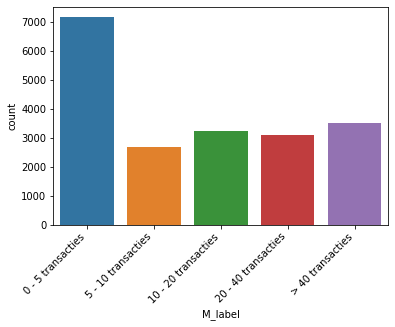

In [12]:
# opdelen in bins obv gem_act_jaar

bins = [0, 5, 10, 20, 40, np.max(dataFLRM['gem_act_jaar'])]
labels = ['0 - 5 transacties', '5 - 10 transacties', '10 - 20 transacties', '20 - 40 transacties', '> 40 transacties']

dataFLRM['M_value'] = pd.cut(dataFLRM['gem_act_jaar'], bins=bins, labels=[1,2,3,4,5], include_lowest=True)
dataFLRM['M_label'] = dataFLRM['M_value'].map(dict(zip([1,2,3,4,5], labels)))

display(dataFLRM.head(3))

fig, ax = plt.subplots()
sns.countplot(data=dataFLRM, x='M_label', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()



## Alles samenbrengen in één tabel

In [13]:
# persoonsgegevens

dataP = data.copy()
dataP = dataP[['id', 'geboortejaar', 'sexe', 'postcode', 'ab_nr']]
dataP = dataP.drop_duplicates(subset=['id'])


# dataPF = dataP.merge(dataF, on='id')
RFM = dataP.merge(dataFLRM, on='id')

RFM['svt'] = RFM['L_label'].astype(str) \
            + ' ' + RFM['R_label'].astype(str) \
            + ' ' + RFM['M_label'].astype(str) \
            + ' ' + RFM['F_label'].astype(str) 

RFM['code'] = RFM['L_value'].astype(str) + RFM['R_value'].astype(str) \
            + RFM['M_value'].astype(str) + RFM['F_value'].astype(str)

display(RFM.head(3))

,id,geboortejaar,sexe,postcode,ab_nr,frequentie,laatst_actief,laatst_actief_jaar,R_value,R_label,...,F_value,F_label,L_value,L_label,totaal,gem_act_jaar,M_value,M_label,svt,code
0,5528102563742870639,1964.0,V,9880,100.0,339,2023-07-18,0.0,5,Minder dan 1 jaar geleden,...,4,> 12 x per jaar,5,meer dan 10 jaar lid,2650.0,117.8,5,> 40 transacties,meer dan 10 jaar lid Minder dan 1 jaar geleden...,5554
1,4384966600680140347,1963.0,V,8730,100.0,106,2023-07-26,0.0,5,Minder dan 1 jaar geleden,...,3,4-12 x per jaar,5,meer dan 10 jaar lid,1545.0,72.5,5,> 40 transacties,meer dan 10 jaar lid Minder dan 1 jaar geleden...,5553
2,-780326536403464828,1957.0,M,9910,100.0,165,2023-07-25,0.0,5,Minder dan 1 jaar geleden,...,3,4-12 x per jaar,5,meer dan 10 jaar lid,1120.0,49.8,5,> 40 transacties,meer dan 10 jaar lid Minder dan 1 jaar geleden...,5553


In [16]:
# RFM.to_csv('RFM_analyse_aalter.csv', sep=';', index=False, decimal=',')
RFM.to_excel('RFM_analyse_aalter.xlsx', index=False)